<a href="https://colab.research.google.com/github/jackseg80/cryptoBot_2023/blob/master/backtest/single_coin/bol_trend/bol_trend_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ccxt

In [ ]:
pip install ta

<H3>Stratégie Bollinger Trend compatible Colab</H3>
Indicateurs: bande de Bollinger + moyenne mobile long terme<br>
SEG

In [32]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np
import seaborn as sns
import datetime

In [33]:
# Module get_data
def get_historical_from_db(exchange, symbol, timeframe, path="database/"):
    symbol = symbol.replace('/','-')
    df = pd.read_csv(filepath_or_buffer=path+str(exchange.name)+"/"+timeframe+"/"+symbol+".csv")
    df = df.set_index(df['date'])
    df.index = pd.to_datetime(df.index, unit='ms')
    del df['date']
    return df

In [34]:
# Module backtesting
def basic_single_asset_backtest(trades, days):
    df_trades = trades.copy()
    df_days = days.copy()
    
    df_days['evolution'] = df_days['wallet'].diff()
    df_days['daily_return'] = df_days['evolution']/df_days['wallet'].shift(1)
    
    df_trades['trade_result'] = df_trades["close_trade_size"] - df_trades["open_trade_size"] - df_trades["open_fee"]
    df_trades['trade_result_pct'] = df_trades['trade_result']/df_trades["open_trade_size"]
    df_trades['trade_result_pct_wallet'] = df_trades['trade_result']/(df_trades["wallet"]+df_trades["trade_result"])
    
    df_trades['wallet_ath'] = df_trades['wallet'].cummax()
    df_trades['drawdown'] = df_trades['wallet_ath'] - df_trades['wallet']
    df_trades['drawdown_pct'] = df_trades['drawdown'] / df_trades['wallet_ath']
    df_days['wallet_ath'] = df_days['wallet'].cummax()
    df_days['drawdown'] = df_days['wallet_ath'] - df_days['wallet']
    df_days['drawdown_pct'] = df_days['drawdown'] / df_days['wallet_ath']
    
    good_trades = df_trades.loc[df_trades['trade_result'] > 0]
    
    initial_wallet = df_days.iloc[0]["wallet"]
    total_trades = len(df_trades)
    total_good_trades = len(good_trades)
    avg_profit = df_trades['trade_result_pct'].mean()   
    global_win_rate = total_good_trades / total_trades
    max_trades_drawdown = df_trades['drawdown_pct'].max()
    max_days_drawdown = df_days['drawdown_pct'].max()
    final_wallet = df_days.iloc[-1]['wallet']
    buy_and_hold_pct = (df_days.iloc[-1]['price'] - df_days.iloc[0]['price']) / df_days.iloc[0]['price']
    buy_and_hold_wallet = initial_wallet + initial_wallet * buy_and_hold_pct
    vs_hold_pct = (final_wallet - buy_and_hold_wallet)/buy_and_hold_wallet
    vs_usd_pct = (final_wallet - initial_wallet)/initial_wallet
    sharpe_ratio = (365**0.5)*(df_days['daily_return'].mean()/df_days['daily_return'].std())
    total_fees = df_trades['open_fee'].sum() + df_trades['close_fee'].sum()
    
    best_trade = df_trades['trade_result_pct'].max()
    best_trade_date1 =  str(df_trades.loc[df_trades['trade_result_pct'] == best_trade].iloc[0]['open_date'])
    best_trade_date2 =  str(df_trades.loc[df_trades['trade_result_pct'] == best_trade].iloc[0]['close_date'])
    worst_trade = df_trades['trade_result_pct'].min()
    worst_trade_date1 =  str(df_trades.loc[df_trades['trade_result_pct'] == worst_trade].iloc[0]['open_date'])
    worst_trade_date2 =  str(df_trades.loc[df_trades['trade_result_pct'] == worst_trade].iloc[0]['close_date'])
    
    print("Période:".ljust(30), "[{}] -> [{}]".format(df_days.iloc[0]["day"], df_days.iloc[-1]["day"]))
    print("Portefeuille initial:".ljust(30), "{:,.2f} $".format(initial_wallet))
    print("\n--- Informations Générales ---")
    print("Portefeuille final:".ljust(30), "{:,.2f} $".format(final_wallet))
    print("Performance vs US dollar:".ljust(30), "{:,.2f} %".format(vs_usd_pct*100))
    print("Pire Drawdown T|D:".ljust(30), "-{}% | -{}%".format(round(max_trades_drawdown*100, 2), round(max_days_drawdown*100, 2)))
    print("Buy and hold performance:".ljust(30), "{} %".format(round(buy_and_hold_pct*100,2)))
    print("Performance vs buy and hold:".ljust(30), "{:,.2f} %".format(vs_hold_pct*100))
    print("Nombre total de trades:".ljust(30), "{}".format(total_trades))
    print("Sharpe Ratio:".ljust(30), "{}".format(round(sharpe_ratio,2)))
    print("Global Win rate:".ljust(30), "{} %".format(round(global_win_rate*100, 2)))
    print("Profit moyen:".ljust(30), "{} %".format(round(avg_profit*100, 2)))
    print("Total des frais:".ljust(30), "{:,.2f} $".format(total_fees))
    print("\033[92m\nMeilleur trade:".ljust(35), "+{:.2f} % le {} -> {}\033[0m".format(best_trade*100, best_trade_date1, best_trade_date2))
    print("\033[91mPire trade:".ljust(35), "{:.2f} % le {} -> {}\033[0m".format(worst_trade*100, worst_trade_date1, worst_trade_date2))
    
    return df_trades, df_days


def plot_sharpe_evolution(df_days):
    df_days_copy = df_days.copy()
    df_days_copy['evolution'] = df_days_copy['wallet'].diff()
    df_days_copy['daily_return'] = df_days_copy['evolution']/df_days_copy['wallet'].shift(1)

    df_days_copy['mean'] = df_days_copy['daily_return'].rolling(365).mean()
    df_days_copy['std'] = df_days_copy['daily_return'].rolling(365).std()
    df_days_copy['sharpe'] = (365**0.5)*(df_days_copy['mean']/df_days_copy['std'])
    df_days_copy['sharpe'].plot(figsize=(18, 9))


def plot_wallet_vs_asset(df_days, log=False):
    days = df_days.copy()
    fig, ax_left = plt.subplots(figsize=(15, 20), nrows=4, ncols=1)

    ax_left[0].title.set_text("Courbe de capital stratégique")
    ax_left[0].plot(days['wallet'], color='royalblue', lw=1)
    if log:
        ax_left[0].set_yscale('log')
    ax_left[0].fill_between(days['wallet'].index, days['wallet'], alpha=0.2, color='royalblue')
    ax_left[0].axhline(y=days.iloc[0]['wallet'], color='black', alpha=0.3)
    ax_left[0].legend(['Evolution du portefeuille (capital)'], loc ="upper left")

    ax_left[1].title.set_text("Evolution de la devise de base ")
    ax_left[1].plot(days['price'], color='sandybrown', lw=1)
    if log:
        ax_left[1].set_yscale('log')
    ax_left[1].fill_between(days['price'].index, days['price'], alpha=0.2, color='sandybrown')
    ax_left[1].axhline(y=days.iloc[0]['price'], color='black', alpha=0.3)
    ax_left[1].legend(["Evolution de l'actif"], loc ="upper left")

    ax_left[2].title.set_text("Courbe du drawdown")
    ax_left[2].plot(-days['drawdown_pct']*100, color='indianred', lw=1)
    ax_left[2].fill_between(days['drawdown_pct'].index, -days['drawdown_pct']*100, alpha=0.2, color='indianred')
    ax_left[2].axhline(y=0, color='black', alpha=0.3)
    ax_left[2].legend(['Drawdown en %'], loc ="lower left")

    ax_right = ax_left[3].twinx()
    if log:
        ax_left[3].set_yscale('log')
        ax_right.set_yscale('log')

    ax_left[3].title.set_text("Portefeuille VS Actif (pas à la même échelle)")
    ax_left[3].set_yticks([])
    ax_right.set_yticks([])
    ax_left[3].plot(days['wallet'], color='royalblue', lw=1)
    ax_right.plot(days['price'], color='sandybrown', lw=1)
    ax_left[3].legend(['Evolution du portefeuille (capital)'], loc ="upper left")
    ax_right.legend(["Evolution de l'actif"], bbox_to_anchor=(0, 0.9), loc ="upper left")

    plt.show()
 
    
def get_metrics(df_trades, df_days):
    df_days_copy = df_days.copy()
    df_days_copy['evolution'] = df_days_copy['wallet'].diff()
    df_days_copy['daily_return'] = df_days_copy['evolution']/df_days_copy['wallet'].shift(1)
    sharpe_ratio = (365**0.5)*(df_days_copy['daily_return'].mean()/df_days_copy['daily_return'].std())
    
    df_days_copy['wallet_ath'] = df_days_copy['wallet'].cummax()
    df_days_copy['drawdown'] = df_days_copy['wallet_ath'] - df_days_copy['wallet']
    df_days_copy['drawdown_pct'] = df_days_copy['drawdown'] / df_days_copy['wallet_ath']
    max_drawdown = -df_days_copy['drawdown_pct'].max() * 100
    
    df_trades_copy = df_trades.copy()
    df_trades_copy['trade_result'] = df_trades_copy["close_trade_size"] - df_trades_copy["open_trade_size"] - df_trades_copy["open_fee"] - df_trades_copy["close_fee"]
    df_trades_copy['trade_result_pct'] = df_trades_copy['trade_result']/df_trades_copy["open_trade_size"]
    df_trades_copy['trade_result_pct_wallet'] = df_trades_copy['trade_result']/(df_trades_copy["wallet"]+df_trades_copy["trade_result"])
    good_trades = df_trades_copy.loc[df_trades_copy['trade_result_pct'] > 0]
    win_rate = len(good_trades) / len(df_trades)
    avg_profit = df_trades_copy['trade_result_pct'].mean()
    
    return {
        "sharpe_ratio": sharpe_ratio,
        "win_rate": win_rate,
        "avg_profit": avg_profit,
        "total_trades": len(df_trades_copy),
        "max_drawdown": max_drawdown
    }
    
    
def get_n_columns(df, columns, n=1):
    dt = df.copy()
    for col in columns:
        dt["n"+str(n)+"_"+col] = dt[col].shift(n)
    return dt


def plot_bar_by_month(df_days):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    custom_palette = {}
    
    last_month = int(df_days.iloc[-1]['day'].month)
    last_year = int(df_days.iloc[-1]['day'].year)
    
    current_month = int(df_days.iloc[0]['day'].month)
    current_year = int(df_days.iloc[0]['day'].year)
    current_year_array = []
    while current_year != last_year or current_month-1 != last_month:
        date_string = str(current_year) + "-" + str(current_month)
        
        monthly_perf = (df_days.loc[date_string]['wallet'].iloc[-1] - df_days.loc[date_string]['wallet'].iloc[0]) / df_days.loc[date_string]['wallet'].iloc[0]
        monthly_row = {
            'date': str(datetime.date(1900, current_month, 1).strftime('%B')),
            'result': round(monthly_perf*100)
        }
        if monthly_row["result"] >= 0:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'g'
        else:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'r'
        current_year_array.append(monthly_row)
        # print(monthly_perf*100) 
        if ((current_month == 12) or (current_month == last_month and current_year == last_year)):
            current_df = pd.DataFrame(current_year_array)
            # print(current_df)
            g = sns.barplot(data=current_df,x='date',y='result', palette=custom_palette)
            for index, row in current_df.iterrows():
                if row.result >= 0:
                    g.text(row.name,row.result, '+'+str(round(row.result))+'%', color='black', ha="center", va="bottom")
                else:
                    g.text(row.name,row.result, '-'+str(round(row.result))+'%', color='black', ha="center", va="top")
            g.set_title(str(current_year) + ' performance en %')
            g.set(xlabel=current_year, ylabel='performance %')
            
            year_result = (df_days.loc[str(current_year)]['wallet'].iloc[-1] - df_days.loc[str(current_year)]['wallet'].iloc[0]) / df_days.loc[str(current_year)]['wallet'].iloc[0]
            print("----- " + str(current_year) +" Performances cumulées: " + str(round(year_result*100,2)) + "%--")
            plt.show()

            current_year_array = []
        
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1

In [35]:
# Module futur_simulations
# Simulations de Monte Carlo (Loi normale)
import random
from sklearn.model_selection import KFold

# Simulation de xxx scénarios
def plot_futur_simulations(df_trades, trades_multiplier, trades_to_forecast, number_of_simulations, true_trades_to_show, show_all_simulations=False):
    sns.set_style("darkgrid")
    sns.set(rc={'figure.figsize':(17,8)})
    plt.title("Simulation de " + str(number_of_simulations) + " scénarios différents")
    inital_wallet = df_trades.iloc[-1]['wallet']
    number_of_trade_last_year = len(df_trades[df_trades["close_date"]>datetime.datetime.now()-datetime.timedelta(days=365)])
    mean_trades_per_day = number_of_trade_last_year/365
    start_date = df_trades.iloc[-1]["close_date"]
    time_list = [(start_date:=start_date+datetime.timedelta(hours=int(24/mean_trades_per_day))) for x in range(trades_to_forecast)]
    trades_pool = list(df_trades["trade_result_pct_wallet"] + 1) * trades_multiplier
    true_trades_date = list(df_trades.iloc[-true_trades_to_show:]["close_date"])
    true_trades_result = list(df_trades.iloc[-true_trades_to_show:]["wallet"])
    mu, sigma = 0, df_trades["trade_result_pct_wallet"].std() # Moyenne et déviation standard
    simulations = {}
    result_simulation = []
    for i in range(number_of_simulations):
        current_trades_pool = random.sample(trades_pool, trades_to_forecast)
        noise_result = np.random.normal(mu, sigma, len(current_trades_pool))
        current_trades_pool = current_trades_pool + noise_result
        curr=1
        current_trades_result = [(curr:=curr*v) for v in current_trades_pool]
        simulated_wallet = [x*inital_wallet for x in current_trades_result]
        result_simulation.append({"key": i, "result": simulated_wallet[-1]})
        simulations[i] =  simulated_wallet
        if show_all_simulations:
            plt.plot(true_trades_date+time_list, true_trades_result+simulated_wallet)
            
    if show_all_simulations == False:
        sorted_simul_result = sorted(result_simulation, key=lambda d: d['result']) 
        for i in range(10):
            index_to_show = i*int(len(sorted_simul_result)/9)
            if index_to_show>=len(sorted_simul_result):
                index_to_show = len(sorted_simul_result)-1
            if i != 9:
                plt.plot(true_trades_date+time_list, true_trades_result+simulations[sorted_simul_result[index_to_show]["key"]])

    plt.show()
    
# Courbe de surapprentissage
def plot_train_test_simulation(df_trades, train_test_date, trades_multiplier, number_of_simulations):
    sns.set_style("darkgrid")
    sns.set(rc={'figure.figsize':(17,8)})
    plt.title("Courbe de surapprentissage sur " + str(number_of_simulations) + " scénarios différents")
    df_train = df_trades.loc[df_trades["close_date"]<train_test_date]
    df_test = df_trades.loc[df_trades["close_date"]>=train_test_date]
    trades_to_forecast = len(df_test)
    inital_wallet = df_train.iloc[-1]['wallet']
    trades_to_show = len(df_test)*2
    time_list = list(df_test["close_date"])
    trades_pool = list(df_train["trade_result_pct_wallet"] + 1) * trades_multiplier
    true_trades_date = list(df_train.iloc[-trades_to_show:]["close_date"])
    true_trades_result = list(df_train.iloc[-trades_to_show:]["wallet"])
    mu, sigma = 0, df_trades["trade_result_pct_wallet"].std() # Moyenne et déviation standard
    simulations = {}
    result_simulation = []
    for i in range(number_of_simulations):
        current_trades_pool = random.sample(trades_pool, trades_to_forecast)
        noise_result = np.random.normal(mu, sigma, len(current_trades_pool))
        current_trades_pool = current_trades_pool + noise_result
        curr=1
        current_trades_result = [(curr:=curr*v) for v in current_trades_pool]
        simulated_wallet = [x*inital_wallet for x in current_trades_result]
        result_simulation.append({"key": i, "result": simulated_wallet[-1]})
        simulations[i] =  simulated_wallet
    sorted_simul_result = sorted(result_simulation, key=lambda d: d['result']) 
    for i in range(10):
        index_to_show = i*int(len(sorted_simul_result)/9)
        if index_to_show>=len(sorted_simul_result):
            index_to_show = len(sorted_simul_result)-1
        if i != 9:
            plt.plot(true_trades_date+time_list, true_trades_result+simulations[sorted_simul_result[index_to_show]["key"]])
            
    plt.plot(true_trades_date+time_list, true_trades_result+list(df_test["wallet"]), linewidth=3.0, color="green")
    plt.show() 


In [36]:
# Stratégie Bollinger Trend
class BolTrend():
    def __init__(
        self,
        df,
        type=["long"],
        bol_window = 100,
        bol_std = 2.25,
        min_bol_spread = 0,
        long_ma_window = 500,
    ):
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.bol_window = bol_window
        self.bol_std = bol_std
        self.min_bol_spread = min_bol_spread
        self.long_ma_window = long_ma_window

    # Indicateurs techniques utilisés dans la stratégie    
    def populate_indicators(self):
        # -- Clear dataset --
        # Les colonnes du jeu de données qui ne sont pas "open", "high", "low", "close" ou "volume" sont supprimées
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        
        # -- Indicateurs techniques --
        bol_band = ta.volatility.BollingerBands(close=df["close"], window=int(self.bol_window), window_dev=int(self.bol_std))
        df["lower_band"] = bol_band.bollinger_lband()
        df["higher_band"] = bol_band.bollinger_hband()
        df["ma_band"] = bol_band.bollinger_mavg()

        df['long_ma'] = ta.trend.sma_indicator(close=df['close'], window=int(self.long_ma_window))

        df = get_n_columns(df, ["ma_band", "lower_band", "higher_band", "close"], 1)
        
        self.df = df    
        return self.df
    
    # Conditions pour long ou short le marché
    def populate_buy_sell(self): 
        df = self.df
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False
        
        if self.use_long:
            # -- Ouverture long market --
            df.loc[
                (df['n1_close'] < df['n1_higher_band']) 
                & (df['close'] > df['higher_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
                & (df["close"] > df["long_ma"]) 
                , "open_long_market"
            ] = True
        
            # -- Fermeture long market --
            df.loc[
                (df['close'] < df['ma_band']) 
                , "close_long_market"
            ] = True

        if self.use_short:
            # -- Ouverture short market --
            df.loc[
                (df['n1_close'] > df['n1_lower_band']) 
                & (df['close'] < df['lower_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
                & (df["close"] < df["long_ma"])
                , "open_short_market"
            ] = True
        
            # -- Fermeture short market --
            df.loc[
                (df['close'] > df['ma_band']) 
                , "close_short_market"
            ] = True
        
        self.df = df   
        return self.df
        
    # Backtest
    def run_backtest(self, initial_wallet=1000, leverage=1, maker_fee=0.0002, taker_fee=0.0007):
        df = self.df[:]
        wallet = initial_wallet
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Ajout au daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check pour la fermeture de position --
                if current_position['side'] == "LONG":                     
                    # -- Fermeture LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Fermeture SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check pour l'ouverture de position --
            else:
                # -- Ouverture long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! Pas de trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        } 

In [37]:
# Choix de la paire à trader et de la timeframe des bougies
pair = "ETH/USDT"
tf = "1h"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../../database/"
)

Période:                       [2018-01-01 00:00:00] -> [2023-01-15 00:00:00]
Portefeuille initial:          1,000.00 $

--- Informations Générales ---
Portefeuille final:            647,940.09 $
Performance vs US dollar:      64,694.01 %
Pire Drawdown T|D:             -26.43% | -31.95%
Buy and hold performance:      110.0 %
Performance vs buy and hold:   30,754.53 %
Nombre total de trades:        263
Sharpe Ratio:                  2.19
Global Win rate:               47.15 %
Profit moyen:                  2.85 %
Total des frais:               39,513.87 $

Meilleur trade:               +61.86 % le 2021-01-02 12:00:00 -> 2021-01-11 00:00:00
Pire trade:                    -9.62 % le 2020-05-07 18:00:00 -> 2020-05-10 00:00:00


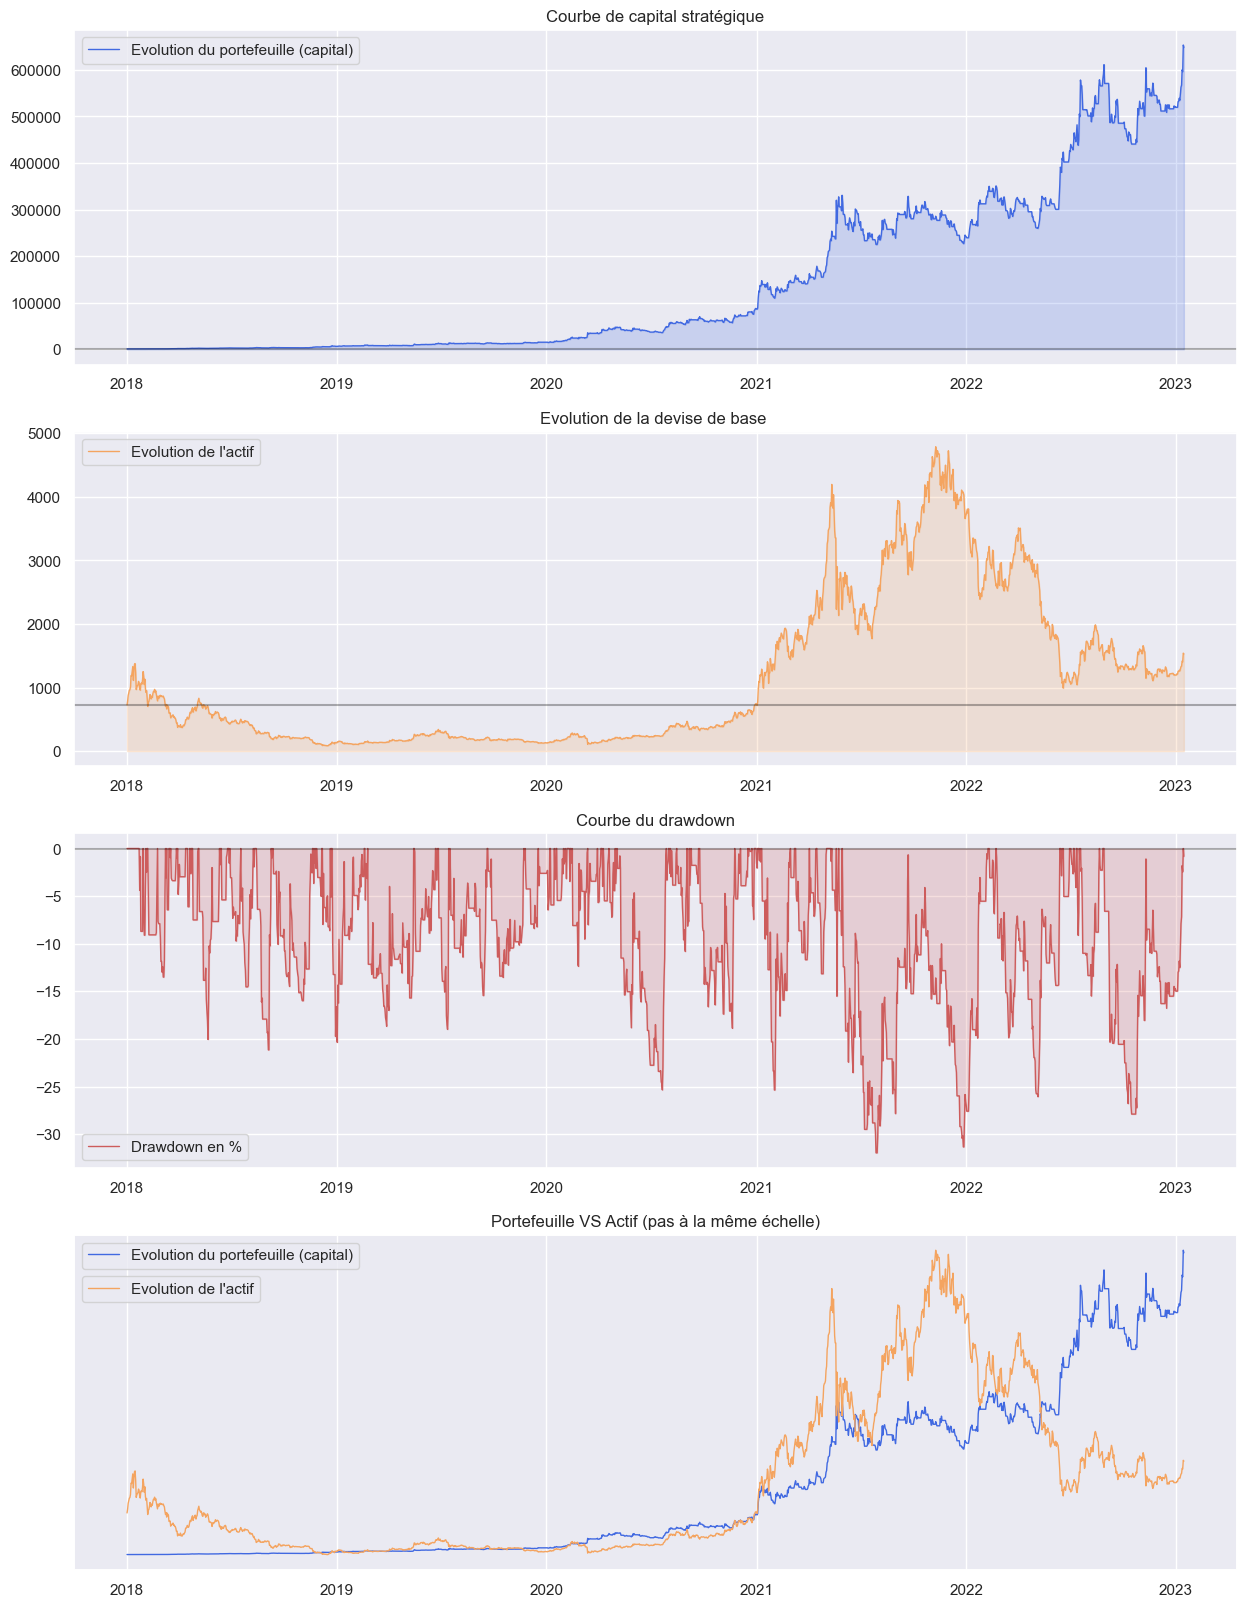

In [38]:
# Paramètres à modifier pour la stratégie
strat = BolTrend(
    df = df.loc["2018":],
    type=["long", "short"],
    bol_window = 100,
    bol_std = 2.2,
    min_bol_spread = 0,
    long_ma_window = 500
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, maker_fee=0.00017, taker_fee=0.00051)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
plot_wallet_vs_asset(df_days=df_days, log=False)

<H2>Courbe de surapprentissage</H2>

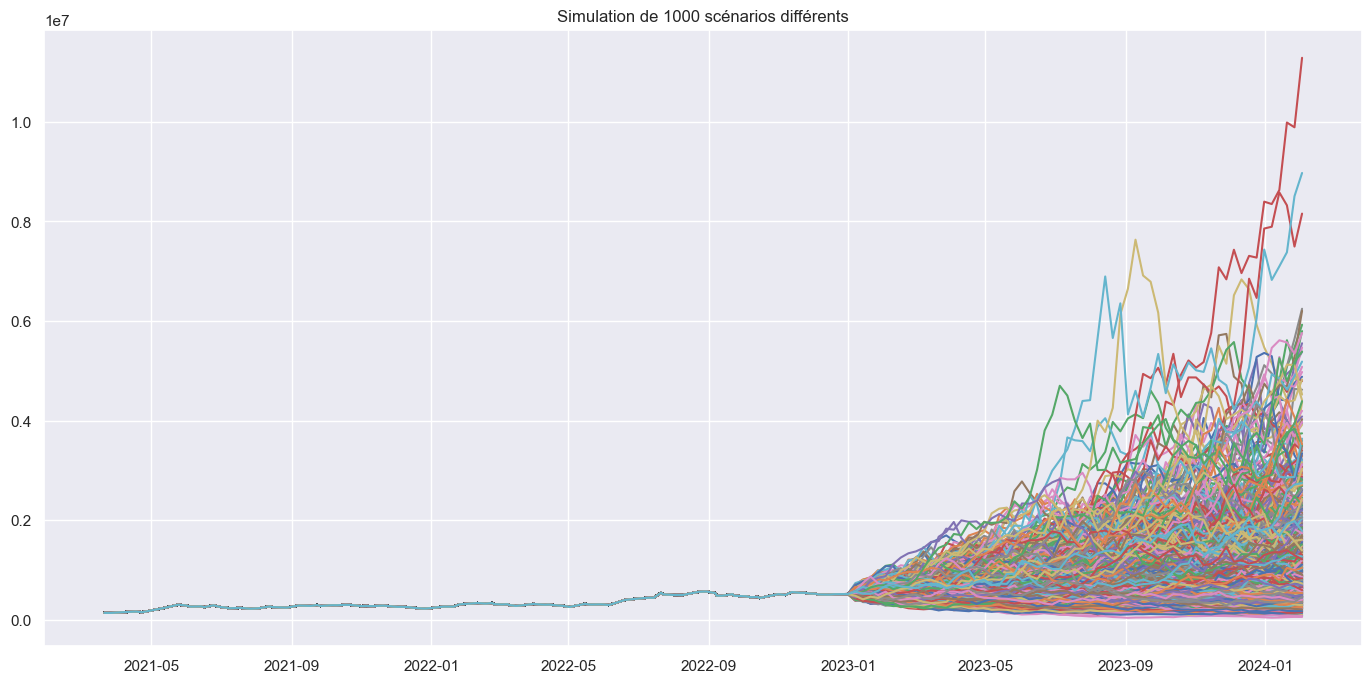

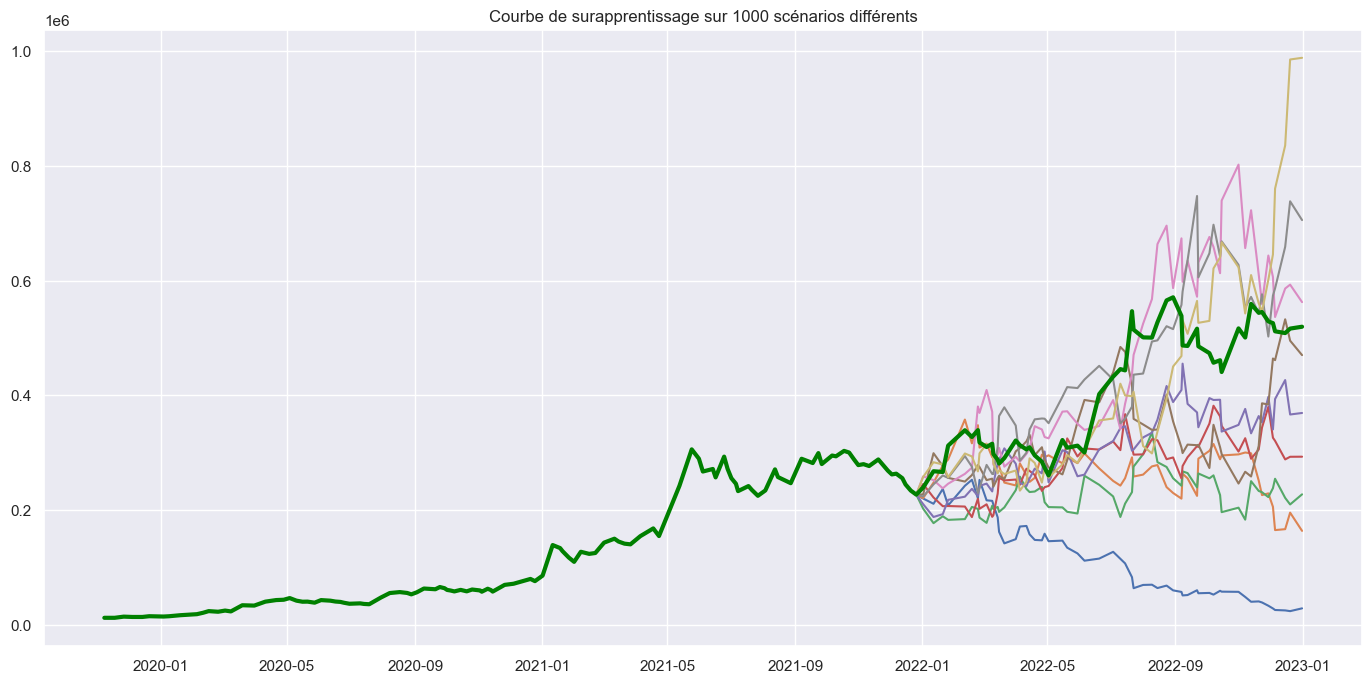

In [39]:
# Simulation de divers scénarios futurs
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=60,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=True
)

# Comparaison entre les divers scénarios et la réalité pour voir si il y a du surapprentissage
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-01-01",
    trades_multiplier=3,
    number_of_simulations=1000,
)

----- 2018 Performances cumulées: 563.42%--


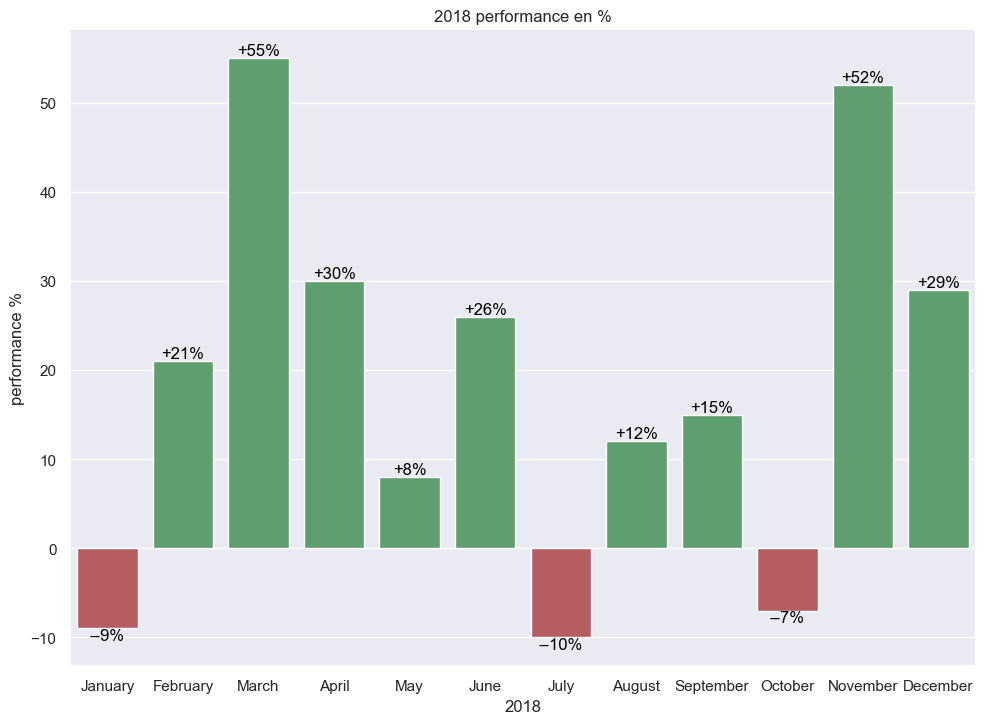

----- 2019 Performances cumulées: 139.49%--


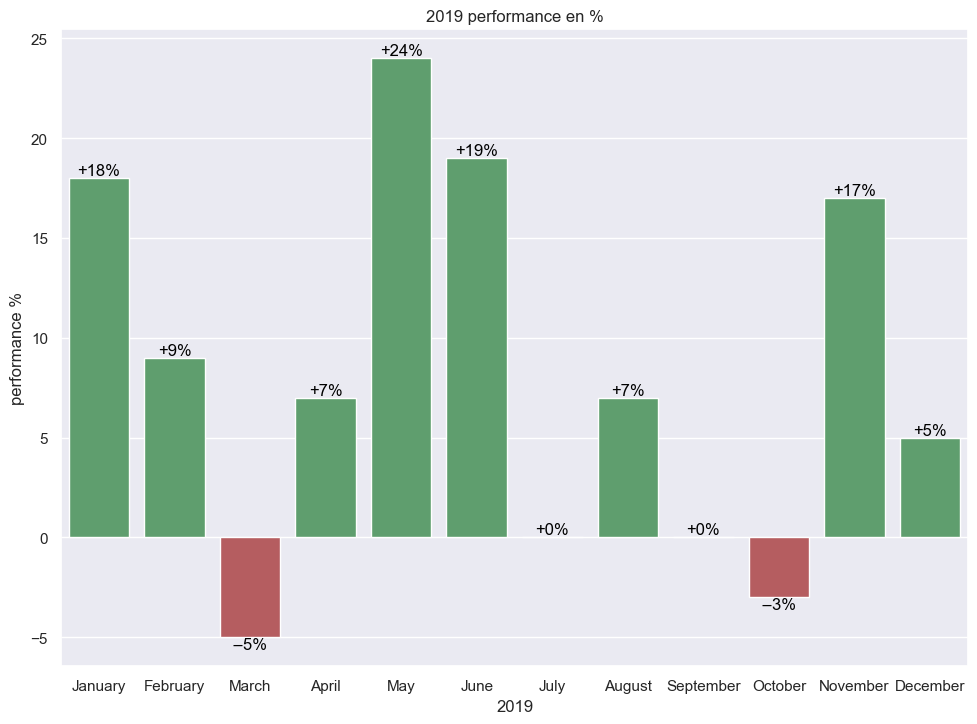

----- 2020 Performances cumulées: 473.03%--


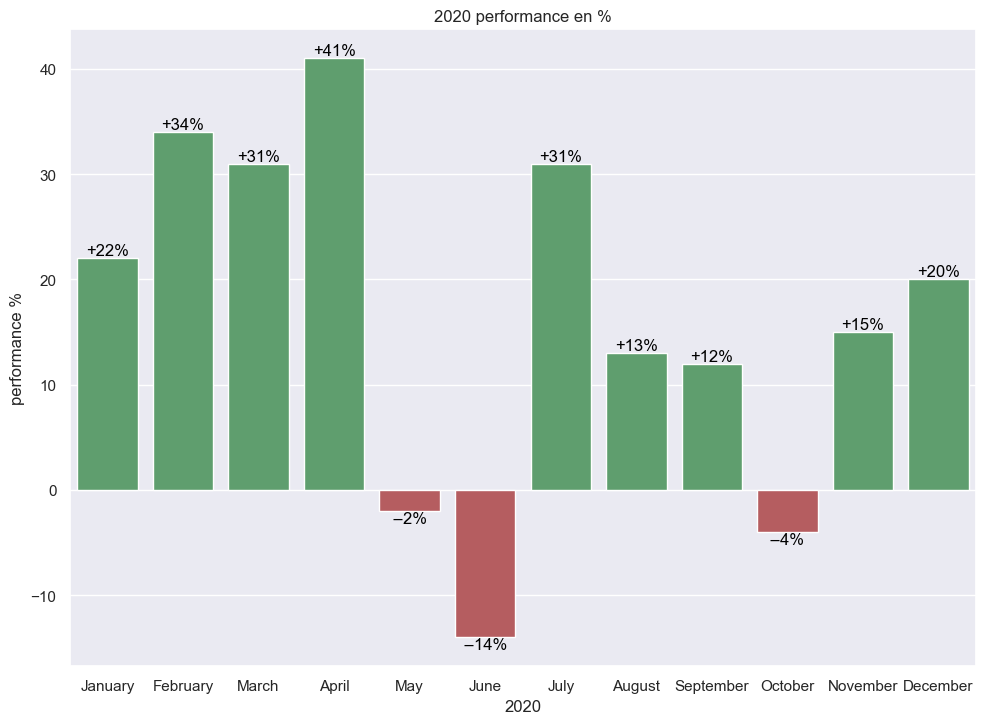

----- 2021 Performances cumulées: 180.76%--


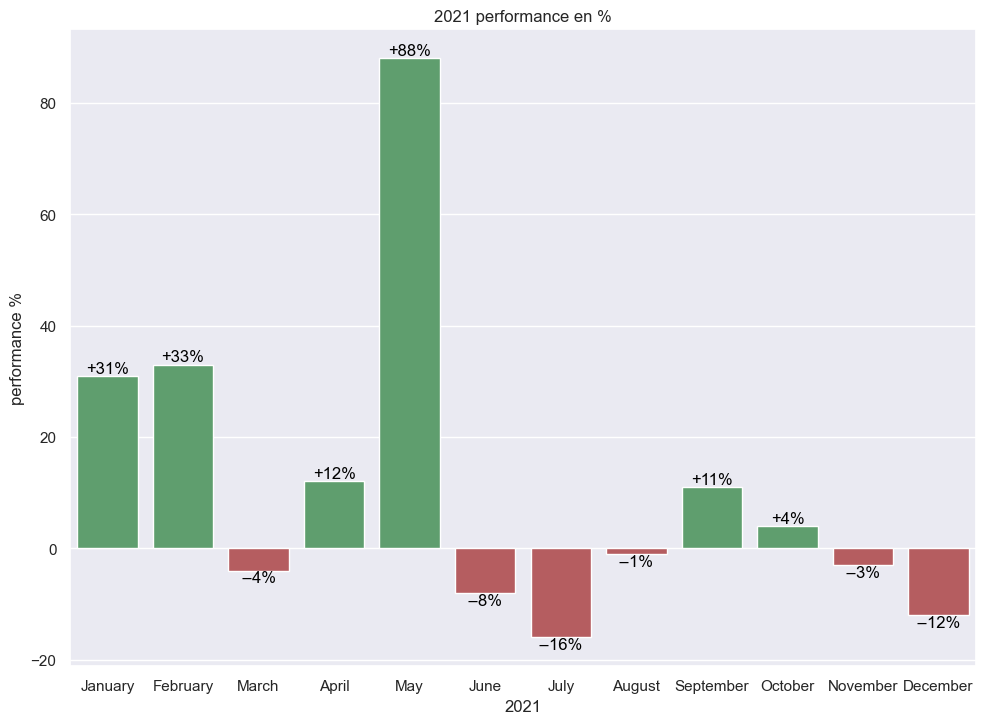

----- 2022 Performances cumulées: 115.63%--


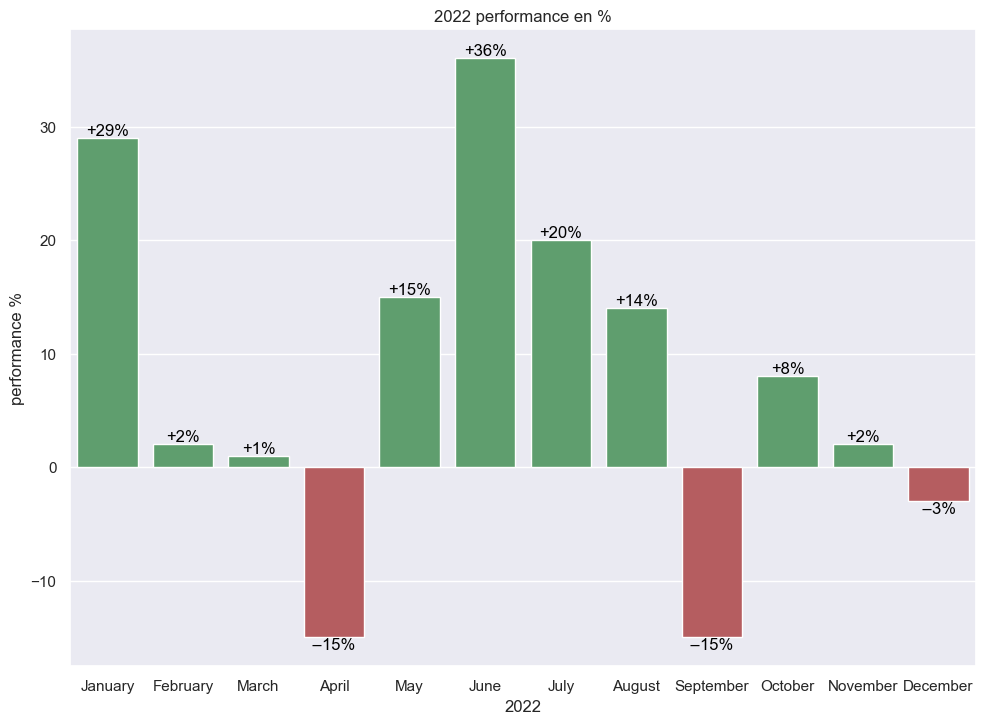

----- 2023 Performances cumulées: 24.7%--


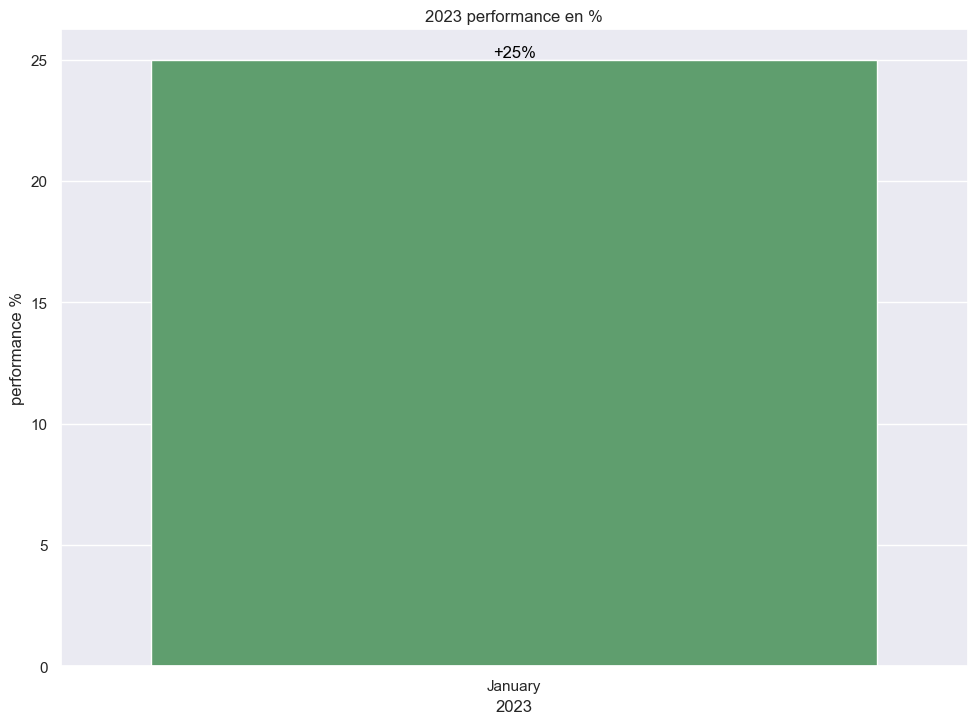

In [40]:
plot_bar_by_month(df_days=df_days)

<H2>Graphique de la balance réelle du wallet Bitget<br>
Robot trading bol_trend</H2>

C:\Users\jacks\AppData\Local\Temp\ipykernel_27196\326173672.py:18: UserWarning:

Parsing '15/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.



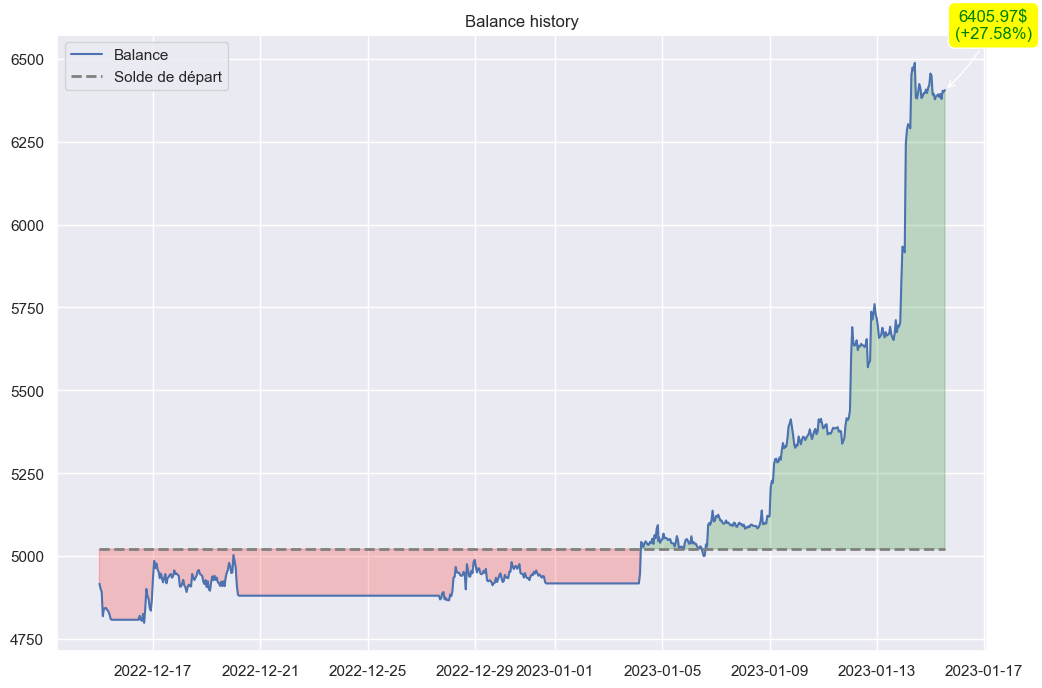

In [41]:
with open("../../../balance_history.txt", "r") as f:
    data = f.read()

lines = data.split("\n")
records = [line.split(";") for line in lines]
records = [record for record in records if len(record) == 2]

df_robot = pd.DataFrame(records, columns=["time", "balance"])
df_robot["time"] = pd.to_datetime(df_robot["time"], format="%d/%m/%Y %H:%M:%S")
df_robot["balance"] = df_robot["balance"].astype(float)

start_balance = 5021
final_balance = df_robot["balance"].iloc[-1]
difference = final_balance - start_balance
percentage_difference = (difference / start_balance) * 100

# Commencer le graphique depuis cette date
start_time = pd.to_datetime("15/12/2022")
df_filtered = df_robot[df_robot["time"] >= start_time]

# Plot graph
plt.figure(figsize=(12, 8))
plt.plot(df_filtered["time"], df_filtered["balance"], '-', label='Balance')
plt.plot([df_filtered["time"].min(), df_filtered["time"].max()], [start_balance, start_balance], '--', color='gray', linewidth=2, label='Solde de départ')
plt.fill_between(df_filtered["time"], df_filtered["balance"], start_balance, where=(df_filtered["balance"] < start_balance), color='red', alpha=0.2)
plt.fill_between(df_filtered["time"], df_filtered["balance"], start_balance, where=(df_filtered["balance"] >= start_balance), color='green', alpha=0.2)

# Gain ou pertes affiché en haut à droite
if percentage_difference >= 0:
    color = "green"
    sign = '+'
else:
    color = "red"
    sign = '-'
plt.annotate(f"{final_balance:.2f}$\n({sign}{percentage_difference:.2f}%)",
             xy=(df_filtered["time"].max(), final_balance), xytext=(35, 35),
             textcoords='offset points', ha='center', va='bottom', color=color,
             bbox=dict(boxstyle='round,pad=0.4', fc='yellow', alpha=1),
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=-0.1', fc='black'))

plt.legend()
plt.title("Balance history")

plt.savefig("balance.png", dpi = 300)
plt.show()

<H2>Optimisation des paramètres</H2>

In [42]:
# Optimisation des paramètres de la stratégie bol_trend sur le sharpe ratio et le winrate
#%%cython
#import cython
from math import ceil
from IPython.display import clear_output
import time
from math import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

dt = None
dt = pd.DataFrame(columns = ['bol_window', 'bol_std', 'long_ma', 'sharpe_ratio', 'win_rate'])

#bol window
#loopI = [30,115,5]
loopI = [20,30,5]   #Pour test rapide
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

#bol std
#loopJ = [10,30,5]
loopJ = [10,20,5]   #Pour test rapide
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

#long ma
#loopK = [300,800,50]
loopK = [300,400,50]    #Pour test rapide
enumK = ceil((loopK[1] - loopK[0]) / loopK[2])

count = 0
maxCount = enumI * enumJ * enumK
for i in range(loopI[0], loopI[1], loopI[2]):
    for j in range(loopJ[0], loopJ[1], loopJ[2]):
         for k in range(loopK[0], loopK[1], loopK[2]):
            new_bol_std=j/10
            clear_output(wait=True)
            count += 1
            print("Loading...",count,'/',maxCount)

            # Paramètres à modifier pour la stratégie
            strat = BolTrend(
                df = df.loc["2020":],
                type=["long","short"],
                bol_window = i,
                bol_std = new_bol_std,
                min_bol_spread = 0,
                long_ma_window = k,
            )

            strat.populate_indicators()
            strat.populate_buy_sell()
            bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, maker_fee=0.00017, taker_fee=0.00051)
            myrow = {'bol_window': i, 'bol_std': new_bol_std, 'long_ma': k, 'sharpe_ratio': bt_result['sharpe_ratio'], 'win_rate': bt_result['win_rate']*100}
            myrow = pd.DataFrame(myrow, index=[0])
            dt = pd.concat([dt, myrow], ignore_index=True)   

# Visualisation 3D des paramètres (ne fonctionne pas pour l'instant)
""" fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dt['bol_window'], dt['bol_std'], dt['long_ma'], c=dt['sharpe_ratio'],cmap='OrRd', s=30)
plt.show() """

dt = dt.sort_values(by=['sharpe_ratio','win_rate'], ascending=False)
fileName = "optimize/optimizer_ETH_1h_v1.csv"
print("Sauvegarde dans le fichier " + fileName)
dt.to_csv(fileName, index=False)
print(dt)

Loading... 8 / 8
Sauvegarde dans le fichier optimize/optimizer_ETH_1h_v1.csv
  bol_window  bol_std long_ma  sharpe_ratio   win_rate
0         20      1.0     300      1.346194  32.216216
2         20      1.5     300      1.346194  32.216216
5         25      1.0     350      1.268179  32.778489
7         25      1.5     350      1.268179  32.778489
4         25      1.0     300      1.267478  33.041302
6         25      1.5     300      1.267478  33.041302
1         20      1.0     350      1.255035  32.083793
3         20      1.5     350      1.255035  32.083793


In [43]:
# Optimisation des paramètres avec optimize.minimize inversé pour la maximisation (1/x)
import scipy.optimize as optimize
import time

def optimize_strategy(parameters):
    # Récupération des paramètres
    bol_window, bol_std, long_ma_window = parameters

    # Initialisation de la stratégie avec les paramètres
    strat = BolTrend(
        df = df.loc["2020":],
        type=["long","short"],
        bol_window = bol_window,
        bol_std = bol_std,
        min_bol_spread = 0,
        long_ma_window = long_ma_window,
    )

    # Exécution de la stratégie
    strat.populate_indicators()
    strat.populate_buy_sell()
    bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, maker_fee=0.00017, taker_fee=0.00051)

    # Calcul du ratio Sharpe
    sharpe_ratio = bt_result['sharpe_ratio']

    # Inversion du ratio Sharpe pour maximiser la valeur (la fonction minimize minimise la valeur)
    return -sharpe_ratio


# Définition des valeurs initiales des paramètres
x0 = [100, 2.25, 500]
bounds = [(50, 120), 
          (1.0, 3.5),
          (200, 800),]

# Exécution de l'optimisation pour chaque combinaison de valeurs initiales
results = []

# Début du chronomètre
start_time = time.time()
result = optimize.minimize(optimize_strategy, x0, bounds=bounds)
results.append(result)
end_time = time.time()
print(f"Temps d'exécution : {end_time - start_time:.2f} secondes")

# Récupération des meilleurs paramètres
best_result = min(results, key=lambda x: x.fun)
bol_window, bol_std, long_ma_window = best_result.x
print(f"Les meilleurs paramètres sont: bol_window={bol_window}, bol_std={bol_std}, long_ma_window={long_ma_window}")


Temps d'exécution : 4.72 secondes
Les meilleurs paramètres sont: bol_window=100.0, bol_std=2.25, long_ma_window=500.0


<H2>Tests divers</H2>

<AxesSubplot: xlabel='date'>

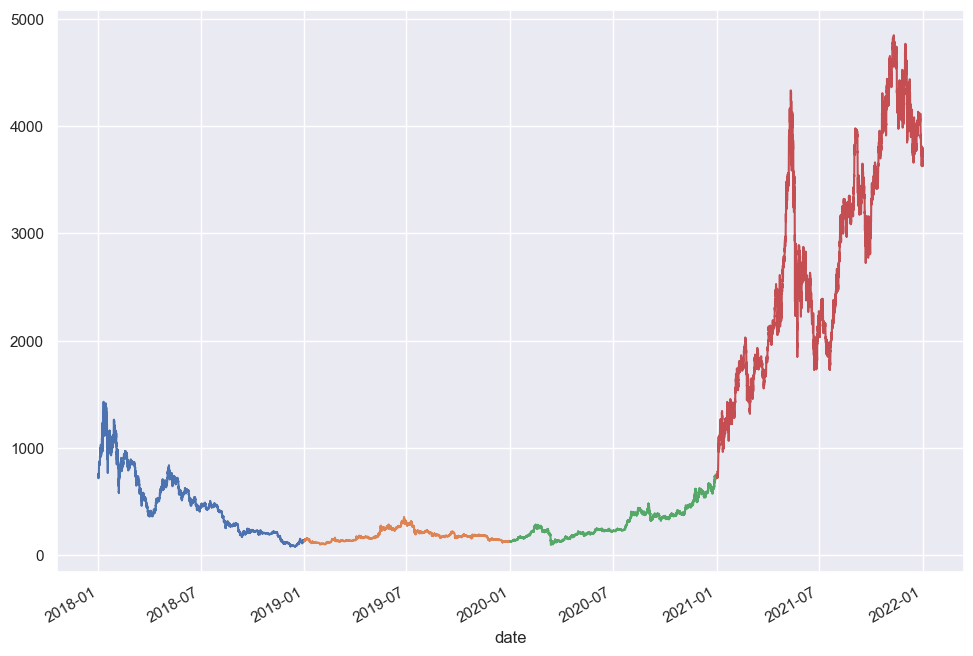

In [44]:
df.loc['2018-01-01':'2018-12-31', 'close' ].plot()
df.loc['2019-01-01':'2019-12-31', 'close' ].plot()
df.loc['2020-01-01':'2020-12-31', 'close' ].plot()
df.loc['2021-01-01':'2021-12-31', 'close' ].plot()

<H2>Test performances Cython</H2>

In [45]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [46]:
%%cython
import cython
from libc.math cimport exp, sqrt, pow, log, erf

@cython.cdivision(True)
@cython.boundscheck(False)
cpdef double std_norm_cdf(double x):
    return 0.5*(1+erf(x/sqrt(2)))

@cython.cdivision(True)
@cython.boundscheck(False)
cpdef double black_scholes_cy(double s, double k, double t, double v, double rf, double div, int cp):
    d1 = (log(s/k)+(rf-div+0.5*pow(v,2))*t)/(v*sqrt(t))
    d2 = d1 - v*sqrt(t)
    optprice = cp*s*exp(-div*t)*std_norm_cdf(cp*d1) - cp*k*exp(-rf*t)*std_norm_cdf(cp*d2)
    return optprice

In [47]:
from math import exp, sqrt, pow, log, erf

def std_norm_cdf_py(x):
    return 0.5*(1+erf(x/sqrt(2.0)))

def black_scholes_py(s, k, t, v, rf, div, cp):
    d1 = (log(s/k)+(rf-div+0.5*pow(v,2))*t)/(v*sqrt(t))
    d2 = d1 - v*sqrt(t)
    optprice = cp*s*exp(-div*t)*std_norm_cdf_py(cp*d1) - \
        cp*k*exp(-rf*t)*std_norm_cdf_py(cp*d2)
    return optprice

In [48]:
%timeit black_scholes_cy(100.0, 100.0, 1.0, 0.3, 0.03, 0.0, -1) #Cython
%timeit black_scholes_py(100.0, 100.0, 1.0, 0.3, 0.03, 0.0, -1) #Python

247 ns ± 19.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
2.54 µs ± 299 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


<H2>Anaylse Bull et Bear Market</H2>

In [49]:
raw_data_btc=pd.read_csv('../../../database/top_100//bitcoin.csv')
raw_data_eth=pd.read_csv('../../../database/top_100//ethereum.csv')

def date_format(df):
    if isinstance(df, pd.DataFrame):
        if 'Date' in df.columns:
            df.Date = pd.to_datetime(df.Date)
            df[['Year','Month','Day']] = df.Date.apply(lambda x: pd.Series(x.strftime("%Y-%m-%d").split("-")))
    else:
        print("Invalid entry, please use a data frame with a Date column.")
    return df

data=date_format(raw_data_btc)
data['Close']=data['Close'].astype(float)
data['Open']=data['Open'].astype(float)
data['High']=data['High'].astype(float)
data['Low']=data['Low'].astype(float)
data['Year']=data['Year'].astype(int)
data['Month']=data['Month'].astype(int)
data['Day']=data['Day'].astype(int)

data_eth=date_format(raw_data_eth)
data_eth['Close']=data_eth['Close'].astype(float)
data_eth['Open']=data_eth['Open'].astype(float)
data_eth['High']=data_eth['High'].astype(float)
data_eth['Low']=data_eth['Low'].astype(float)
data_eth['Year']=data_eth['Year'].astype(int)
data_eth['Month']=data_eth['Month'].astype(int)
data_eth['Day']=data_eth['Day'].astype(int)


In [50]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Ohlc(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close']))

fig.update_layout(template='plotly_dark',
    height = 550,
    title='Prix BTC au fil des ans',
    xaxis_title="Années",
    yaxis_title='Prix BTC',title_x=0.5,
    shapes = [dict(x0='2017-09-01', x1='2017-09-01', y0=0, y1=1, xref='x', yref='paper',line_width=2),
              dict(x0='2018-01-10', x1='2018-01-10', y0=0, y1=1, xref='x', yref='paper',line_width=2),
              dict(x0='2020-11-01', x1='2020-11-01', y0=0, y1=1, xref='x', yref='paper',line_width=2),
             dict(x0='2021-05-01', x1='2021-05-01', y0=0, y1=1, xref='x', yref='paper',line_width=2)],
    annotations=[dict(x='2017-01-01', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bull🐂'),
        dict(x='2018-01-10', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bear🐻'),
        dict(x='2020-11-01', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bull🐂'),
        dict(x='2021-08-01', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bear🐻')],
    updatemenus=[
        dict(type='buttons',
             buttons=[dict(label='Linear', method='relayout',args=[{'yaxis.type': 'linear'}]),
                      dict(label='Log', method='relayout', args=[{'yaxis.type': 'log'}])],
                      x=0, y=1.3, bgcolor = 'gray', bordercolor = 'blue', borderwidth = 2, font = dict(color = 'black')
            )]
)

fig.update_yaxes(
    tickprefix="$", showgrid=True
)

fig.update_xaxes(
     showgrid=True
)

fig.show()

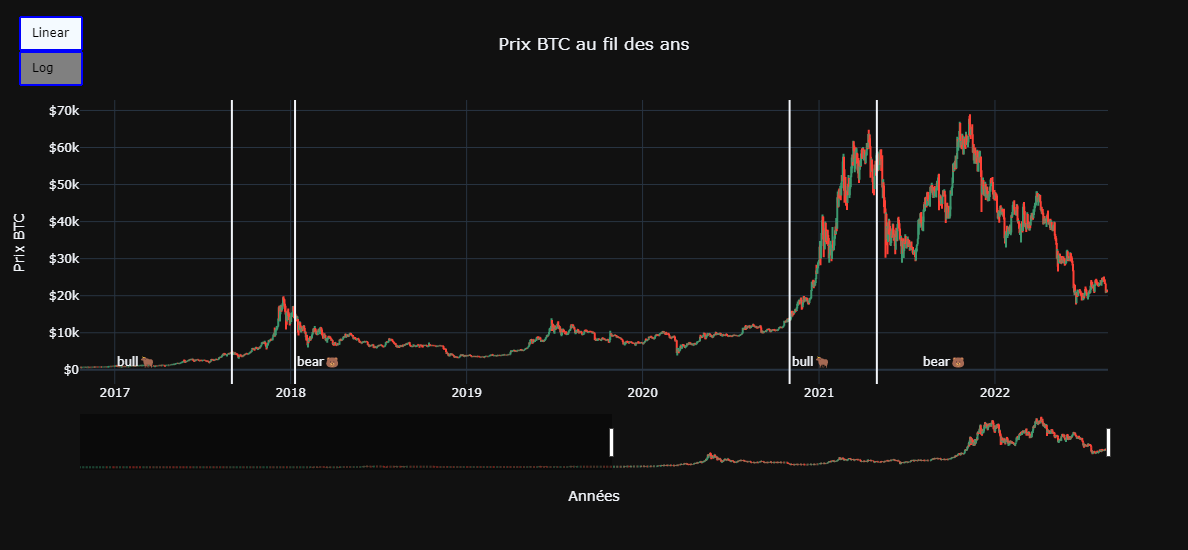

In [51]:
from IPython.display import Image
Image("BTC_bull_bear.png")